<a href="https://colab.research.google.com/github/Perales64/ControlTemperaturaPID/blob/main/TemperaturaPID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Temperatura PID

Necesitamos conocer la temperatura que entra y sale del sistema. Usaremos ecuaciones para modelar el sistema térmico.

Temperatura de entrada: Aumenta cuando la corriente eléctrica fluye por el transistor.

Temperatura de salida: La energía se dispersa por convección y radiación.
$$\frac{ΔQ}{Δt}=Q_{in}-Q_{out}$$
Temperatura de entrada:
$$Q_{in}-\alpha Q_i$$

$Q_i$ es el porcentaje de salida del calentador. El parámetro α es un factor que relaciona la salida del calentador $(0-100\%)$ con la potencia disipada por el transistor en vatios.
La temperatura de salida es dada por:
$$Q_{out}=k_T​(T−T_∞)+ϵσA(T^4
 −T^4_∞)$$

El primer término de la ecuación se conoce como la Ley de enfriamiento de newton y el segundo como la Ley de Stefan-Boltzmann

$k_T$ constante de perdida para el ambiente, $T$ temperatura del transistor,
$T_\infty$ temperatura del ambiente, ϵ  emisividad, $σ$ es la constante de Stefan-Boltzmann, $A$ es el área
donde:
$$kT=UA$$
$U$ es el coeficiente de transferencia de calor, $A$ es el área
Reemplazando valores tenemos que:
$$\dfrac{\Delta Q}{\Delta t}=\alpha Q_i+UA(T_{\infty}-T)+\epsilon \sigma A (T_{\infty}^4-T^4)$$
tilizando el concepto de derivada

$$\dfrac{d Q}{d t}=\alpha Q_i+UA(T_{\infty}-T)+\epsilon \sigma A (T_{\infty}^4-T^4)$$
Podemos calcular el calor liberado o absorbido utilizando el calor específico, $c_p$, la masa, $m$, del componente y el cambio en temperatura $(T-T_{ref})$ en la ecuación:
$$Q=mc_p(T−T_{ref})$$
reemplazando tenemos:
$$mc_p\dfrac{d T}{d t}-mc_p\dfrac{d T_{ref}}{d t}=\alpha Q_i+UA(T_{\infty}-T)+\epsilon \sigma A (T_{\infty}^4-T^4)$$
Considerando que la temperatura de referencia es constante, por lo tanto la derivada da CERO, llegamos al modelo matemático de la temperatura del transistor:

$$mc_p\dfrac{d T}{d t}=\alpha Q_i+UA(T_{\infty}-T)+\epsilon \sigma A (T_{\infty}^4-T^4)$$

## Parametros del modelo

In [1]:
#@title Librerias
!pip install control
!pip install serial

In [2]:
# @title Tabla de Parametros {"run":"auto","display-mode":"form"}
import pandas as pd

# Define los datos
data = {
    'Parámetro': ['Temperatura inicial (T0)', 'Temperatura Ambiente (T∞)', 'Salida del Calentador (Q)', 'Factor del Calentador (α)', 'Capacidad Calorifica (Cp)', 'Area de la superficie (A)', 'Masa (m)', 'Coeficiente de transferencia de calor(U)', 'Emisividad (ε)', 'Stefan Boltzmann Constant (σ)'],
    'Valor': ['296.15 K (23oC)', '296.15 K (23oC)', '1', '0.014', '500 J/kg-K', '1.2e-3', '0.004 kg (4 gm)', '5', '0.9', '5.67e-8'],
    'Unidad': ['K', 'K', 'W', 'W/(% heater)', 'J/kg-K', 'm2', 'kg', 'W/m2-K', '', 'W/m2-K4']
}
# Create a Pandas DataFrame from the data
df = pd.DataFrame(data)  # This line creates the DataFrame
# Solicitar al usuario los valores en Celsius
temp_inicial_c = float(input("Ingresa la temperatura inicial en Celsius: "))
temp_ambiente_c = float(input("Ingresa la temperatura ambiente en Celsius: "))

# Convertir a Kelvin
temp_inicial_k = temp_inicial_c + 273.15
temp_ambiente_k = temp_ambiente_c + 273.15

# Actualizar los valores en el DataFrame
df.loc[df['Parámetro'] == 'Temperatura inicial (T0)', 'Valor'] = temp_inicial_k
df.loc[df['Parámetro'] == 'Temperatura Ambiente (T∞)', 'Valor'] = temp_ambiente_k

# Mostrar el DataFrame actualizado
display(df)

Ingresa la temperatura inicial en Celsius: 23
Ingresa la temperatura ambiente en Celsius: 23


,Parámetro,Valor,Unidad
0,Temperatura inicial (T0),296.15,K
1,Temperatura Ambiente (T∞),296.15,K
2,Salida del Calentador (Q),1,W
3,Factor del Calentador (α),0.014,W/(% heater)
4,Capacidad Calorifica (Cp),500 J/kg-K,J/kg-K
5,Area de la superficie (A),1.2e-3,m2
6,Masa (m),0.004 kg (4 gm),kg
7,Coeficiente de transferencia de calor(U),5,W/m2-K
8,Emisividad (ε),0.9,
9,Stefan Boltzmann Constant (σ),5.67e-8,W/m2-K4


## Linealización del Modelo Térmico
Por causa del término de $T^4$ agregado por la ecuación de radiación de la lay de Stefan Boltzmann, el modelo fenomenológico de la temperatura del transistor es NO lineal.

Procedemos a linealizar el modelo en un punto de equilibrio usando la expansion por series de Taylor.

Comenzamos definiendo el modelo como una función f:
$$f(T,Q_i)=\dfrac{d T}{d t}=\dfrac{\alpha}{mc_p} Q_i+\dfrac{UA}{mc_p}(T_{\infty}-T)+\dfrac{\epsilon \sigma A}{mc_p} (T_{\infty}^4-T^4)$$

## Punto de Equilibrio
En el punto de equilibrio la derivada es nula, debido a que ya no existe más variación de temperatura dado que el sistema se ha estacionado.
$$0=αQ_{is}+UA(T_{∞s}−T_s)+ϵσA(T_{∞s}^4−T_s^4)$$

De esa forma llegamos a una ecuación algebraica de orden 4:
$$(ϵσA)T_s^4+(UA)T_s−(αQ_{is}+UAT_{∞s}+ϵσAT_{∞s}^4)=0$$

Debemos encontrar las raíces de la ecuación anterior (serán 4 raíces) y seleccionar únicamente la raíz positiva. Note que la ecuación anterior depende de la entrada Q_{is} que será la cantidad de potencia que vamos a aplicar al transistor para que genere calor.

In [3]:
# @title Calculo punto de equilibrio
import numpy as np
from IPython.display import display, Markdown
eps = float(df.loc[df['Parámetro'] == 'Emisividad (ε)', 'Valor'].iloc[0])
sigma = float(df.loc[df['Parámetro'] == 'Stefan Boltzmann Constant (σ)', 'Valor'].iloc[0])
A = float(df.loc[df['Parámetro'] == 'Area de la superficie (A)', 'Valor'].iloc[0])
U = float(df.loc[df['Parámetro'] == 'Coeficiente de transferencia de calor(U)', 'Valor'].iloc[0])
Qi = float(df.loc[df['Parámetro'] == 'Salida del Calentador (Q)', 'Valor'].iloc[0])
Ta = float(df.loc[df['Parámetro'] == 'Temperatura Ambiente (T∞)', 'Valor'].iloc[0])
alpha = float(df.loc[df['Parámetro'] == 'Factor del Calentador (α)', 'Valor'].iloc[0])


def T_ss(eps, sigma, A, U, Qi, Ta, alpha):
    # Coefficients of the polynomial: eps*sigma*A*T^4 + U*A*T - alpha*Qi - U*A*Ta - eps*sigma*A*Ta^4
    p = [eps * sigma * A, 0, 0, U * A, -alpha * Qi - U * A * Ta - eps * sigma * A * Ta**4]

    # Find roots of the polynomial
    roots = np.roots(p)

    # Filter real positive roots
    Ts = []
    for root in roots:
        if np.isreal(root) and root > 0:
            Ts.append(np.real(root))

    TK = float(Ts[0])
    TC = TK - 273.15

    return TK, TC

TK, TC = T_ss(eps, sigma, A, U, Qi, Ta, alpha)
texto_md = f"""
- **Temperatura Kelvin:** ${TK:.2f}$ K
- **Temperatura Celsius:** ${TC:.2f}$ °C

Fórmula usada:
$$ Q = \epsilon \sigma A (T^4 - T_a^4) $$
"""
display(Markdown(texto_md))


- **Temperatura Kelvin:** $297.28$ K
- **Temperatura Celsius:** $24.13$ °C

Fórmula usada:
$$ Q = \epsilon \sigma A (T^4 - T_a^4) $$


## Series de Taylor
Aplicando las series de Taylor:
Realizando las derivadas parciales con relación a la temperatura y a la entrada evaluando todo en los puntos de equilibrio encontrados anteriormente llegamos a la siguiente ecuación:
$$
\dfrac{dT}{dt}=\left(-\dfrac{UA}{mc_p}-\dfrac{4\epsilon \sigma A}{mc_p} T_s^3\right)\Delta T+\left( \dfrac{\alpha}{mc_p}\right)\Delta Q+\left.\begin{matrix}\dfrac{dT}{dt}\end{matrix}\right|_{T_s,Q_{is}}$$
$$\dfrac{d\Delta T}{dt}=\left(-\dfrac{UA}{mc_p}-\dfrac{4\epsilon \sigma A}{mc_p} T_s^3\right)\Delta T+\left( \dfrac{\alpha}{mc_p}\right)\Delta Q$$

## Función de Transferencia
Aplicando la transformada de Laplace al modelo lineal encontrado usando las series de Taylor:
$$
\dfrac{\Delta T(s)}{\Delta Q(s)}=\dfrac{\left( \dfrac{\alpha}{mc_p}\right)}{s+\left(\dfrac{UA}{mc_p}+\dfrac{4\epsilon \sigma A}{mc_p} T_s^3\right)}$$
Reemplazando los valores de la tabla y encontrando un punto de equilibrio cuando no estoy inyectando potencia en el transistor Q_{is}=0.

In [4]:
#@title Calculo Función de Transferencia
import pandas as pd
import control
import numpy as np
from IPython.display import display, Math
# ... (previous code from the provided file) ...

# Assuming 'df' DataFrame is already created and populated as in the provided code.

def calculate_transfer_function(df):
    """Calculates the transfer function parameters."""

    # Extract parameters from the DataFrame.  Error handling added for robustness.
    try:
        alpha = float(df.loc[df['Parámetro'] == 'Factor del Calentador (α)', 'Valor'].iloc[0].split(' ')[0].split('/')[0])
        m = float(df.loc[df['Parámetro'] == 'Masa (m)', 'Valor'].iloc[0].split(' ')[0])
        cp = float(df.loc[df['Parámetro'] == 'Capacidad Calorifica (Cp)', 'Valor'].iloc[0].split(' ')[0])
        U = float(df.loc[df['Parámetro'] == 'Coeficiente de transferencia de calor(U)', 'Valor'].iloc[0].split(' ')[0])
        A = float(df.loc[df['Parámetro'] == 'Area de la superficie (A)', 'Valor'].iloc[0].replace('×10-3', 'e-3').split(' ')[0])
        eps = float(df.loc[df['Parámetro'] == 'Emisividad (ε)', 'Valor'].iloc[0])
        sigma = float(df.loc[df['Parámetro'] == 'Stefan Boltzmann Constant (σ)', 'Valor'].iloc[0].replace('×10-8', 'e-8'))
        Ts, _ = T_ss(eps, sigma, A, U, 0, float(df.loc[df['Parámetro'] == 'Temperatura Ambiente (T∞)', 'Valor'].iloc[0]), alpha) # Equilibrium temperature when Qi=0

    except (ValueError, IndexError, AttributeError) as e:
        print(f"Error extracting parameters from DataFrame: {e}")
        return None, None, None


    # Calculate transfer function components
    num = alpha / (m * cp)
    den_s = 1
    den_const = (U * A / (m * cp)) + (4 * eps * sigma * A * Ts**3 / (m * cp))

    return num, den_s, den_const

# Calcular la función de transferencia
num, den_s, den_const = calculate_transfer_function(df)

if num is not None and den_const is not None:
    # Formatear la función de transferencia
    tf_str = f"G(s) = {num:.4f} / (s + {den_const:.4f})"
    # Mostrar la función de transferencia en LaTeX
    display(Math(f"$$ G(s) = \\frac{{{num:.4f}}}{{s + {den_const}}} $$"))
else:
    print("No se pudo calcular la función de transferencia.")

<IPython.core.display.Math object>

# Funcion en un Sistema de primer orden
Forma estándar de un sistema de primer orden:
La forma estándar de un sistema de primer orden es:
$$G(s)=\frac{K}{τs+1}$$
donde:

$K$ es la ganancia en estado estacionario,

$τ \ $ es la constante de tiempo.

In [5]:
#@title Calculo Primer Orden
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown
# Convertir a la forma estándar de primer orden
K = num / den_const # Ganancia en estado estacionario
tau = 1 / den_const     # Constante de tiempo

Sistema1_md = rf"""
$$K = \frac{{{num:.3f}}}{{{den_const:.2f}}} = {K:.2f}$$
$$\tau = \frac{{1}}{{{den_const:.2f}}} = {tau:.2f}$$
$$G(s) = \frac{{{K:.4f}}}{{{tau:.4f}s + 1}}$$
"""
display(Markdown(Sistema1_md))


$$K = \frac{0.007}{0.01} = 1.13$$
$$\tau = \frac{1}{0.01} = 161.78$$
$$G(s) = \frac{1.1325}{161.7845s + 1}$$


Ingresa K: 120


/usr/local/lib/python3.11/dist-packages/control/rlocus.py:210: FutureWarning: root_locus() return value of roots, gains is deprecated; use root_locus_map()
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/control/pzmap.py:372: UserWarning: axis already exists; grid keyword ignored
  warnings.warn("axis already exists; grid keyword ignored")


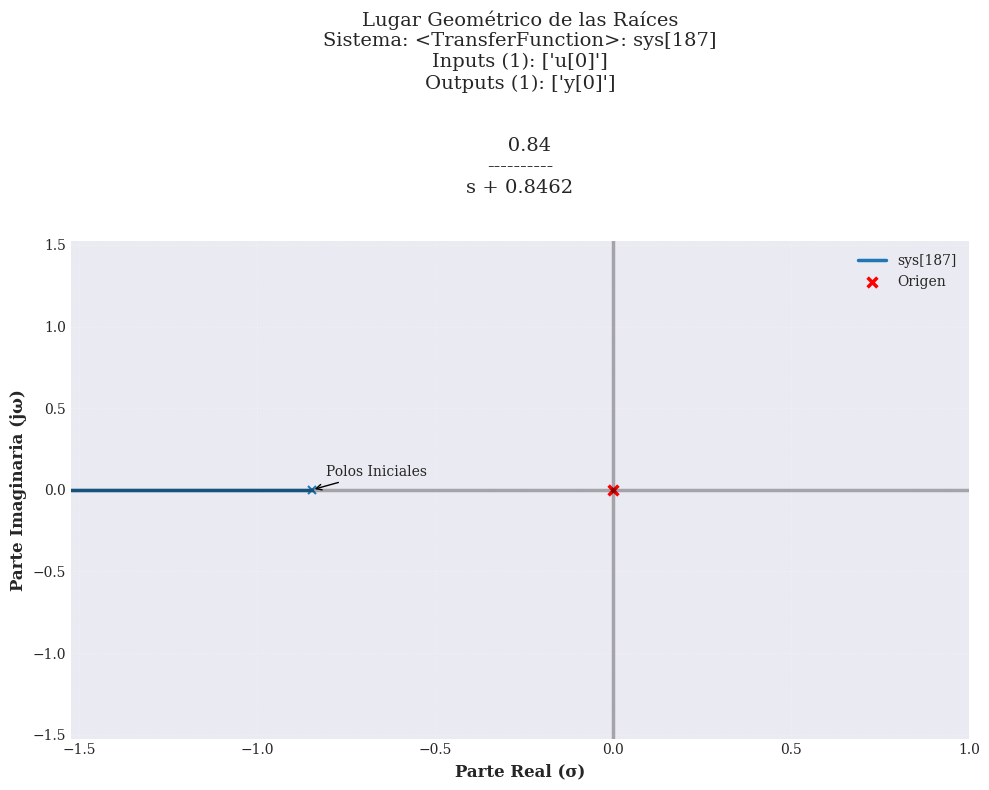

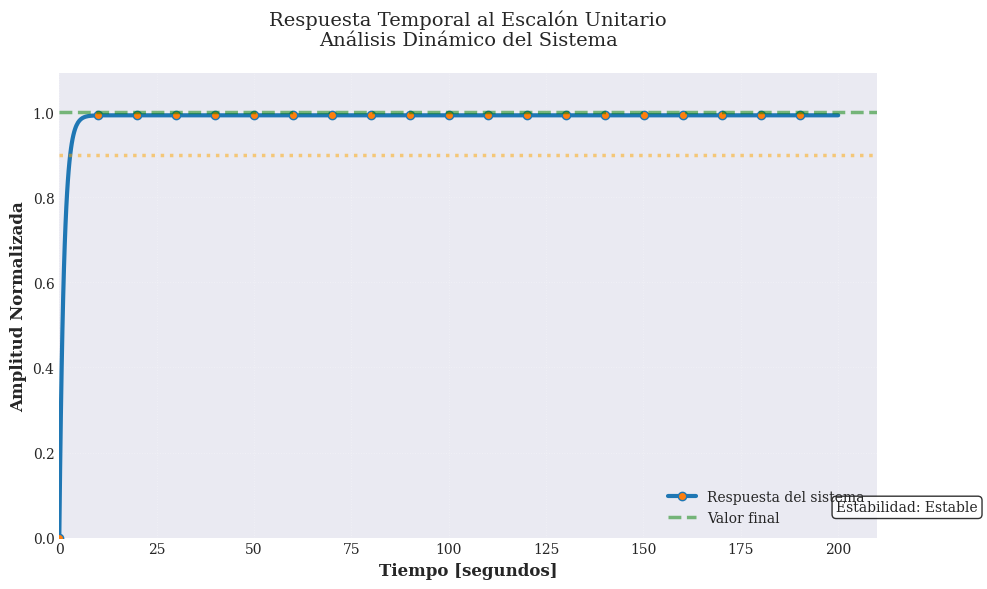

In [36]:
# @title Graficas
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt

escalon=ctrl
den=[1,den_const]
## Calcular el control lazo cerrado
K = float(input("Ingresa K: "))
sys=ctrl.TransferFunction(num,den)
lazo_cerrado= ctrl.feedback(K*sys)
# Simulación de la respuesta al escalón
time = np.linspace(0, 200, 1000)
time_step, response_step = ctrl.step_response(lazo_cerrado, time)

# Configuración de estilo profesional
plt.style.use('seaborn-v0_8-darkgrid')  # Fondo con grid sutil
params = {
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'font.family': 'serif',
    'grid.alpha': 0.3,
    'grid.linestyle': ':',
    'lines.linewidth': 2.5
}
plt.rcParams.update(params)

# ----------------------------------------------------------
# Lugar Geométrico de las Raíces (Mejorado)
# ----------------------------------------------------------
fig1, ax1 = plt.subplots(figsize=(10, 8))
ctrl.root_locus(lazo_cerrado, plot=True, grid=False, ax=ax1)

# Personalización avanzada
ax1.set_title("Lugar Geométrico de las Raíces\nSistema: {}".format(lazo_cerrado), pad=20)
ax1.set_xlabel("Parte Real (σ)", fontweight='bold')
ax1.set_ylabel("Parte Imaginaria (jω)", fontweight='bold')

# Resaltar ejes y origen
ax1.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax1.axvline(x=0, color='k', linestyle='-', alpha=0.3)
ax1.scatter(0, 0, color='red', s=50, marker='x', label='Origen')

# Mejorar la leyenda
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc='upper right', framealpha=1)

# Añadir anotaciones
ax1.annotate('Polos Iniciales',
             xy=(handles[0].get_data()[0][0], handles[0].get_data()[1][0]),
             xytext=(10, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

fig1.tight_layout()
plt.show()

# ----------------------------------------------------------
# Respuesta al Escalón (Versión Premium)
# ----------------------------------------------------------
fig2, ax2 = plt.subplots(figsize=(10, 6))

# Gráfico principal con estilo mejorado
main_line = ax2.plot(time_step, response_step,
                    label="Respuesta del sistema",
                    color="#1f77b4",
                    linewidth=3,
                    marker='o',
                    markevery=int(len(time_step)/20),
                    markersize=6,
                    markerfacecolor='#ff7f0e',
                    markeredgewidth=1)

# Resaltar características importantes
max_overshoot = max(response_step)
if max_overshoot > 1:  # Si hay sobreimpulso
    idx_max = np.argmax(response_step)
    ax2.annotate(f'Sobreimpulso: {100*(max_overshoot-1):.1f}%',
                xy=(time_step[idx_max], max_overshoot),
                xytext=(10, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", color='r'),
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

# Líneas de referencia
ax2.axhline(y=1, color='green', linestyle='--', alpha=0.5, label='Valor final')
ax2.axhline(y=0.9, color='orange', linestyle=':', alpha=0.5)
ax2.axhline(y=1.1, color='orange', linestyle=':', alpha=0.5)

# Personalización del gráfico
ax2.set_title("Respuesta Temporal al Escalón Unitario\nAnálisis Dinámico del Sistema", pad=20)
ax2.set_xlabel("Tiempo [segundos]", fontweight='bold')
ax2.set_ylabel("Amplitud Normalizada", fontweight='bold')
ax2.grid(True, which='both', linestyle=':', linewidth=0.7)

# Leyenda mejorada
ax2.legend(loc='lower right', framealpha=1, shadow=True)

# Ajustar límites para mejor visualización
ax2.set_xlim(left=0)
ax2.set_ylim(bottom=min(0, min(response_step)*1.1),
             top=max(response_step)*1.1)

# Añadir cuadro de texto con parámetros
textstr = f"Estabilidad: {'Estable' if max(response_step) < 1.5 else 'Crítica'}"
ax2.text(0.95, 0.05, textstr, transform=ax2.transAxes,
        fontsize=10, verticalalignment='bottom',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

fig2.tight_layout()
plt.show()

In [8]:
import serial  # Asegúrate de que sea pyserial
from datetime import datetime

# Configura el puerto correcto (verifica con list_ports)
puerto = 'COM3'  # Ejemplo para Windows
baudrate = 9600

try:
    # Intenta abrir el puerto serial
    with serial.Serial(puerto, baudrate, timeout=1) as ser:
        print(f"Conexión exitosa con {puerto}")

        # Guarda los datos en un CSV
        nombre_archivo = f"mediciones_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        with open(nombre_archivo, 'a') as archivo:
            archivo.write("FechaHora,Medicion\n")  # Encabezado

            print("Guardando datos... (Presiona Ctrl+C para detener)")
            try:
                while True:
                    linea = ser.readline().decode('utf-8').strip()
                    if linea:
                        fecha_hora = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                        archivo.write(f"{fecha_hora},{linea}\n")
                        archivo.flush()  # Guarda inmediatamente
                        print(f"Dato: {linea}")
            except KeyboardInterrupt:
                print("\nMedición detenida por el usuario.")

except Exception as e:  # Captura cualquier error genérico
    print(f"Error: {e} (¿El puerto {puerto} existe?)")

Error: module 'serial' has no attribute 'Serial' (¿El puerto COM3 existe?)
